In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import pandas as pd

def visualize_trajectory(nrows=3, ncols=1):
    plt.rcParams["font.size"] = 16
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16.0, 8.0), squeeze=False)
    for k in range(K):
        df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[:,k], "y":all_evalpoint_np[:,k]})
        df = df[df.y != 0]
        df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[:,k], "y":all_given_np[:,k]})
        df2 = df2[df2.y != 0]
        row = k
        axes[row][0].plot(range(0,L), quantiles_imp[2][:,k], color = 'g',linestyle='solid',label='CSDI') # the median line
        axes[row][0].fill_between(range(0,L), quantiles_imp[1][:,k],quantiles_imp[3][:,k], color='g', alpha=0.3) # the 1Q and 3Q
        axes[row][0].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
        axes[row][0].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
        plt.setp(axes[row,0], xlabel='time in 0.1s')
        if k == 0:
            plt.setp(axes[row,0], ylabel='position')
        elif k == 1:
            plt.setp(axes[row,0], ylabel='speed')
        elif k == 2:
            plt.setp(axes[row,0], ylabel='acceleration')
        axes[row,0].spines[['right', 'top']].set_visible(False)
    plt.tight_layout()

# Visualize Traj Imputation Results

In [2]:
nsample = 5 # number of generated samples (in CSDI settings)
K = 3 # number of features (in trajectory: position, speed, acceleration)

resultfolder = 'traj_imputation_20240918_122536'
result_path = './save/'+resultfolder+'/result_nsample' + str(nsample) + '.pk'
with open(result_path, 'rb') as f:
    RMSE_average, MAE_average, RMSE_pos, RMSE_spd, RMSE_acc, MAE_pos, MAE_spd, MAE_acc = pickle.load(f) # the last metric is reserved

print(f"RMSE average = {RMSE_average:.2f}, RMSE pos = {RMSE_pos:.2f}m, RMSE spd = {RMSE_spd:.2f}m/s, RMSE acc = {RMSE_acc:.2f}m/s^2")
print(f" MAE average = {MAE_average:.2f},  MAE pos = {MAE_pos:.2f}m,  MAE spd = {MAE_spd:.2f}m/s,  MAE acc = {MAE_acc:.2f}m/s^2")

RMSE average = 5.18, RMSE pos = 8.91m, RMSE spd = 0.96m/s, RMSE acc = 0.36m/s^2
 MAE average = 1.25,  MAE pos = 3.24m,  MAE spd = 0.35m/s,  MAE acc = 0.16m/s^2


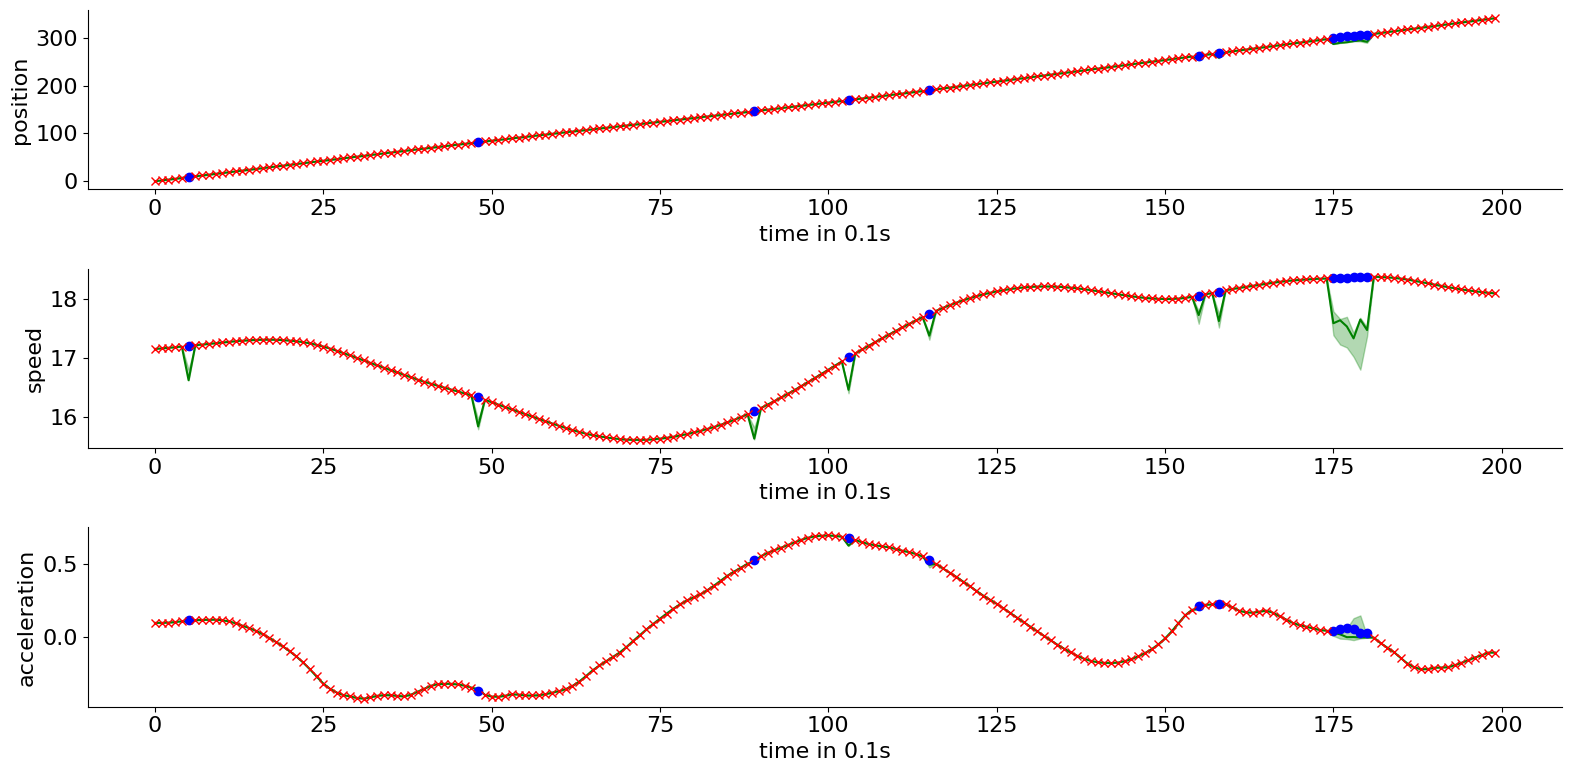

In [3]:
dataset = 'trajectory' # choose 'healthcare' or 'airquality'
datafolder = 'traj_imputation_20240918_122536' # set the folder name

segment_id = 3 # target segment to visualize
local_veh_id = 5 # target local vehicle id to visualize
path = './save/'+datafolder+'/seg' + str(segment_id) + '_localvehid' + str(local_veh_id) + '_nsample' + str(nsample) + '.pk'

with open(path, 'rb') as f:
    samples, all_target, all_evalpoint, all_observed, all_observed_time, scaler, mean_scaler = pickle.load(f)

samples = samples.permute(1, 0, 2, 3).reshape(nsample, -1, K)
L = samples.shape[-2] # time length of the whole segment after reshaping
all_target = all_target.reshape(-1, 3)
all_evalpoint = all_evalpoint.reshape(-1, 3)
all_observed = all_observed.reshape(-1, 3)
all_observed_time = all_observed_time.reshape(-1)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append( torch.quantile(samples,q,dim=0).cpu().numpy() *(1-all_given_np) + all_target_np * all_given_np)

visualize_trajectory()